# DL_2

## Importing Necessary Libraries and Datasets

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd


In [ ]:
# creating a directory for graphs and results
import os # for directory creation

def create_folder(dir_name):

  # Check if the folder exists
  if os.path.exists(os.getcwd() + '/' + dir_name):
    print("The folder "+ dir_name +" exists.")

  else:
    os.makedirs(dir_name)
    print("Folder "+ dir_name +" created succesfully.")

create_folder('result_files')
create_folder('result_files/balance')
create_folder('result_files/loss_plots')
create_folder('result_files/model_files/CNN/models')
create_folder('result_files/model_files/DNN/models')
create_folder('result_files/model_files/CNN/histories')
create_folder('result_files/model_files/DNN/histories')
create_folder('result_files/model_files/CNN/best_model')
create_folder('result_files/model_files/DNN/best_model')


The folder result_files exists.
The folder result_files/balance exists.
The folder result_files/loss_plots exists.
The folder result_files/model_files/CNN/models exists.
The folder result_files/model_files/DNN/models exists.
The folder result_files/model_files/CNN/histories exists.
The folder result_files/model_files/DNN/histories exists.
The folder result_files/model_files/CNN/best_model exists.
The folder result_files/model_files/DNN/best_model exists.


## Loading the Data

In [ ]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X, y), (X_test, y_test) = mnist.load_data()

# preprocessing test data
X_test = X_test.reshape(-1, 28 * 28)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# printing out the shapes
X.shape, y.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 784), (10000, 10))

## Class Balance

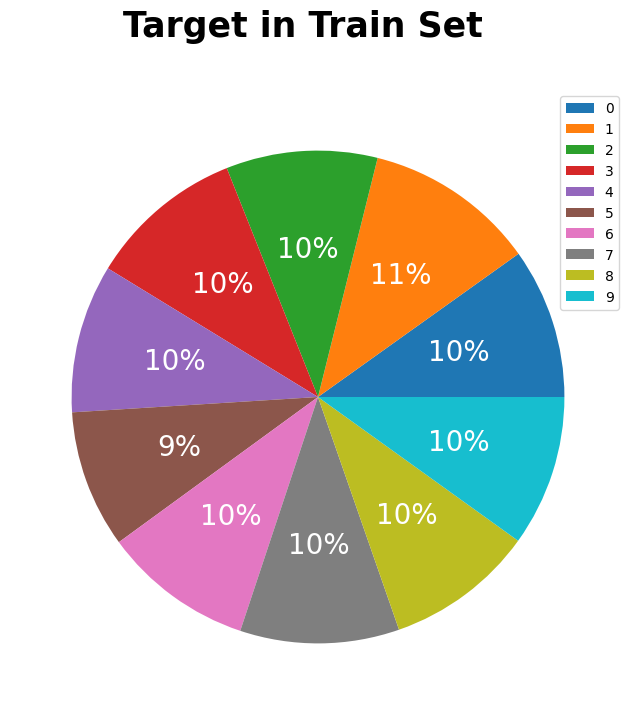

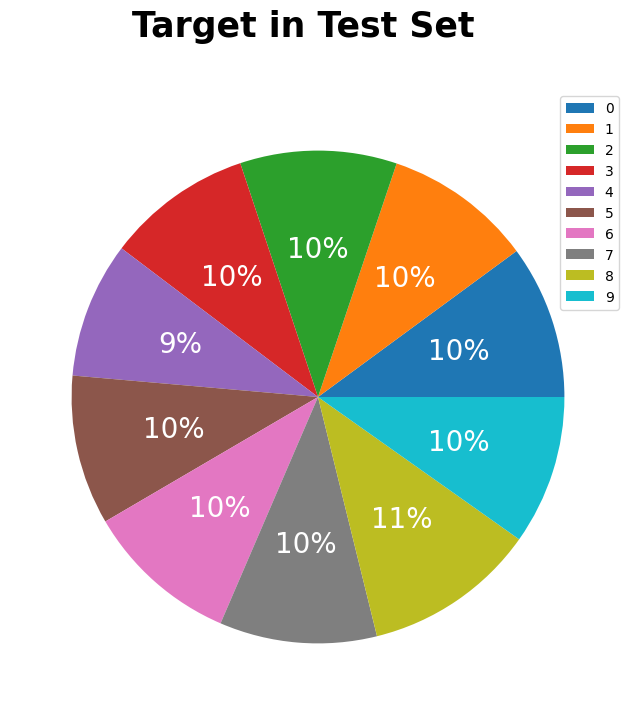

In [ ]:
# creating a function that helps in class balance visualization
def balance_viz(y, set_type='', filename=''):
  plt.figure(figsize=(12, 8))

  # creating a pie that displayes the target value percentages
  counts = y.value_counts().sort_index()
  plt.pie(
      counts,
      autopct='%1.f%%',
      textprops={'size' : 20, 'color' : 'white'},
      labels=[str(i) for i in range(10)]

  )

  # adding title
  plt.suptitle(f'Target in {set_type} Set', fontsize=25, fontweight='bold')
  plt.legend()

  # saving the figure
  plt.savefig('result_files/balance/' + filename, bbox_inches='tight')
  plt.show()

# plotting the target balance in the data
balance_viz(pd.DataFrame(y), 'Train', 'balance_data_train.png')

balance_viz(pd.DataFrame(y_test), 'Test', 'balance_data_test.png')

## Helper Functions

### Function for metric calculations

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def clf_metrics(y_true, y_pred_labels):
  # calculating accuracy, precision, recall, and F1-score
  accuracy = accuracy_score(y_true, y_pred_labels)
  precision = precision_score(y_true, y_pred_labels, average='macro')
  recall = recall_score(y_true, y_pred_labels, average='macro')
  f1 = f1_score(y_true, y_pred_labels, average='macro')

  # printing the evaluation metrics
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}\n")



## Model Experiment Class Creation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, \
                            accuracy_score
from sklearn.model_selection import StratifiedKFold

class Model_Experiment():

  def __init__(self, create_model):
    self.create_model = create_model

    # creating a results dataframe to save the evaluations
    self.results_df = pd.DataFrame(columns=['Technique Name', 'Set',
                                            'Fold Number', 'Accuracy',
                                            'Precision', 'Recall',
                                            'F1-Score'])



  # function for transforming predictions
  # to one-hot vectors
  def one_hot_pred(self, y_pred):
    pred_oh = np.zeros_like(y_pred)
    pred_oh[np.argmax(y_pred)] = 1

    return pred_oh

  # a function for making predictions with the given model
  def make_predictions(self, model, X):

    # making predictions and transforming them to one-hot vectors
    return np.array([self.one_hot_pred(pred)
                    for pred in model.predict(X, verbose=False)])

  # a function for evaluating the model
  def evaluate_model(self, y_true, y_pred, average='macro'):

    # evaluating the model
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,
                                average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    return accuracy, precision, recall, f1

  # function for adding the evaluations to the results dataframe
  def add_results(self, evals, results_df, set_type, tech_name, fold_number):

    # creating the new row(the results) for the results df
    fold_eval = {
        'Technique Name' : tech_name,
        'Set' : set_type,
        'Fold Number' : fold_number,
        'Accuracy' : evals[0],
        'Precision' : evals[1],
        'Recall' : evals[2],
        'F1-Score' : evals[3]
    }

    # concating the previous dataframe with the new row
    results_df = pd.concat([results_df, pd.DataFrame([fold_eval])],
                          ignore_index=True)

    return results_df

  # a function for choosing a random configuration for
  # all parameters from the parameter space
  def get_random_config(self, param_space, model_type='dnn',
                        dropout_prob=0.5, random_state=None):

      if random_state != None:
        random.seed(random_state)

      # picking the batch_size and epochs
      batch_size = random.choice(param_space['batch_size'])
      epochs = random.choice(param_space['epochs'])

      # picking the number of layers from the available choices
      num_layers = random.choice(param_space['num_layers'])

      # getting a random configuration of units and dropouts
      num_units = random.choices(param_space['num_units'], k=num_layers)

      # the empty tuple means that the layer does not have dropout
      # the dropout gets assigned with probability dropout_prob
      dropouts = random.choices(param_space['dropouts'], k=num_layers,
                                weights=[1 - dropout_prob, dropout_prob/4,
                                        dropout_prob/4, dropout_prob/4,
                                        dropout_prob/4])
      if model_type == 'cnn':

        num_filters = random.choices(param_space['num_filters'])
        filter_sizes = random.choices(param_space['filter_sizes'], k=num_layers)
        pool_sizes = random.choices(param_space['pool_sizes'], k=num_layers)

        return batch_size, epochs, num_layers, num_units, dropouts,\
               num_filters, filter_sizes, pool_sizes

      return batch_size, epochs, num_layers, num_units, dropouts


  def k_fold_split(self, X, y, n_splits,
                   train_size, val_size, num_classes=10, model_type='dnn'):

    # creating an instance of StratifiedKFold with 6 folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    folds = []
    for index_1, index_2 in skf.split(X, y):

      # index_1 corresponds to train and index_2 corresponds to test
      # I will combine them in order to choose how many folds to use
      # for each set on my own.
      indexes = np.concatenate((index_1, index_2), axis=0)

      train_index = indexes[0: train_size]
      val_index = indexes[train_size: train_size + val_size]


      # splitting the fold data to train val test according to the indexes
      X_train, X_val = X[train_index], X[val_index]
      y_train, y_val = y[train_index], y[val_index]

      # converting class vectors to binary class matrices
      y_train = keras.utils.to_categorical(y_train, num_classes)
      y_val = keras.utils.to_categorical(y_val, num_classes)

      # preprocessing the features
      X_train = X_train.reshape(-1, 28 * 28) / 255.0
      X_val = X_val.reshape(-1, 28 * 28) / 255.0

      if model_type == 'cnn':
        X_train = X_train.reshape(-1, 28, 28)
        X_val = X_val.reshape(-1, 28, 28)

      # storing the fold
      fold = [(X_train, y_train), (X_val, y_val)]
      folds.append(fold)

    return folds

  def train_evaluate(self, param_space, num_configs, folds,
                     X_test, y_test,
                     num_classes=10, dropout_prob=0.2, model_type='dnn'):

    models = [] # here the models will be stored
    models_results_df = [] # here the results of all the models will be added
    models_hist = {} # here the history of the models will be added

    best_accuracy = 0.0
    best_params = {}

    # for every configuration, perform k-fold cross validation
    for j in range(num_configs):

      # for every configuration we use a different results_df and
      # at the end we take the results df of the model that we will select
      model_results_df = self.results_df.copy() # emptying the results_df from previous inputs

      if model_type == 'dnn':
        # choose a random model configuration
        batch_size, epochs, num_layers, num_units, dropouts = \
            self.get_random_config(param_space=param_space,
                              dropout_prob=dropout_prob)
        # creating the model
        model, tech_name = self.create_model(num_layers, num_units, dropouts)

      elif model_type == 'cnn':

        # choose a random model configuration
        batch_size, epochs, num_layers, num_units, dropouts, num_filters, filter_sizes, pool_sizes = \
            self.get_random_config(param_space=param_space,
                              dropout_prob=dropout_prob, model_type=model_type)

        # creating the model
        model, tech_name, max_pool_num = self.create_model(num_layers, num_units, num_filters,
                                             filter_sizes, pool_sizes, dropouts)

      # printing info
      print(f'Model {j + 1}')

      # evaluations of the model in the folds
      fold_evals = []
      fold_hist = {}
      for i in range(len(folds)):

        (X_train, y_train), (X_val, y_val) = folds[i]

        # training the model on the current fold train set
        hist = model.fit(X_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_val, y_val),
                  verbose=True)

        # saving the history for the current fold
        fold_hist[f'Fold_{i + 1}'] = hist

        # making predictions
        y_pred_train = self.make_predictions(model, X_train)
        y_pred_val = self.make_predictions(model, X_val)


        # making predictions on test set
        y_pred_test = self.make_predictions(model, X_test)

        # evaluating the model
        train_eval = self.evaluate_model(y_train, y_pred_train)
        val_eval = self.evaluate_model(y_val, y_pred_val)
        test_eval = self.evaluate_model(y_test, y_pred_test)

        # storing the test set evaluation
        fold_evals.append(test_eval)

        # printing information on training for the validation set
        print(f'- Fold {i + 1} Finished. '
              f'Validation Set Evaluations : accuracy = {val_eval[0]}, '
              f'precision = {val_eval[1]}, recall = {val_eval[2]}, '
              f'f1 = {val_eval[3]} \n')

        # adding evaluations to the results dataframe
        model_results_df = self.add_results(train_eval, model_results_df,
                                            'Train', tech_name, fold_number=i+1)
        model_results_df = self.add_results(test_eval, model_results_df, 'Test',
                                tech_name, fold_number=i+1)


      # storing the model in the models list
      models.append(model)

      # saving the history of the model
      models_hist[f'Model_{j + 1}'] = fold_hist

      # adding the results dataframe to the list for the current configuration
      models_results_df.append(model_results_df)


      # transforming the evaluations to a np.array
      fold_evals = np.array(fold_evals)

      # calculating the mean of each metric
      eval_avg = np.mean(fold_evals, axis=0)
      print(f'\n\nModel {j + 1} average evaluation '
            f'(Test Set) : accuracy = {eval_avg[0]}, '
            f'precision = {eval_avg[1]}, recall = {eval_avg[2]}, '
            f'f1 = {eval_avg[3]} \n\n')

      if model_type == 'dnn':

        # updating the best parameters if the current configuration is better
        # based on the accuracy of the model
        accuracy = eval_avg[0]
        if accuracy > best_accuracy:
          best_dnn_model_idx = j
          model_name = f'Model {j + 1}'
          best_accuracy = accuracy
          best_params = {
          'batch_size' : batch_size,
          'epochs' : epochs,
          'num_layers' :num_layers + 1, # adding 1 to account for the last dense layer
          'num_units' : num_units,
          'dropouts' : dropouts
          }

      else :

        # updating the best parameters if the current configuration is better
        # based on the accuracy of the model
        accuracy = eval_avg[0]
        if accuracy > best_accuracy:
          best_cnn_model_idx = j
          model_name = f'Model {j + 1}'
          best_accuracy = accuracy
          best_params = {
          'batch_size' : batch_size,
          'epochs' : epochs,
          'num_layers' : num_layers + 2, # for the last two dense layers
          'num_units' : num_units,
          'dropouts' : dropouts,
          'num_filters' : num_filters,
          'filter_sizes' : filter_sizes,
          'num_pools' : max_pool_num,
          'pool_sizes' : pool_sizes
          }

    if model_type == 'dnn':
      # printing the best parameters
      print(f'Best Model -> {model_name}')
      print(f'\nHyper-parameters : \n-Batch size -> {best_params["batch_size"]}'\
            f'\n-Epochs -> {best_params["epochs"]}' \
            f'\n-Number of Layers -> {best_params["num_layers"]}' \
            f'\n-Number of units in each layer -> {best_params["num_units"]}' \
            f'\n-Dropouts in each Layer -> {best_params["dropouts"]}')

      print(f'\nTest Set Average Accuracy = {best_accuracy}')
      best_model_idx = best_dnn_model_idx

    else:
      # printing the best parameters
      print(f'Best Model -> {model_name}')
      print(f'\nHyper-parameters : \n-Batch size -> {best_params["batch_size"]}'\
            f'\n-Epochs -> {best_params["epochs"]}' \
            f'\n-Number of Layers -> {best_params["num_layers"]}' \
            f'\n-Number of units in dense layers -> {best_params["num_units"]}'\
            f'\n-Number of filters in convolution Layers -> {best_params["num_filters"]}' \
            f'\n-Size of filters in convolution layers -> {best_params["filter_sizes"]}'\
            f'\n-Number of Max Pooling layers -> {best_params["num_pools"]}'\
            f'\n-Size of Max-Pooling layers -> {best_params["pool_sizes"]}'\
            f'\n-Dropouts in each Layer -> {best_params["dropouts"]}')

      print(f'\nTest Set Average Accuracy  = {best_accuracy}')

      best_model_idx = best_cnn_model_idx


    return models, models_results_df, best_model_idx, models_hist


## DNN Model

### Model Creation

In [ ]:
import random
# a function for creating the DNN model
def create_dnn_model(num_layers, num_units, dropouts,
                     num_classes=10, model_summary=False):

  # creating the model
  model = Sequential()

  # adding layers to the model with the given units and dropouts
  for i in range(num_layers):

    if i == 0:
      # the first layer accepts the inputs
      model.add(Dense(num_units[i],  activation='relu', input_shape=(28 * 28,)))

      # checking if the layer has dropouts
      if dropouts[i] != ():
        model.add(Dropout(dropouts[i]))

    else:

      # adding layers
      model.add(Dense(num_units[i], activation='relu'))

      # checking if the layer has been given dropouts
      if dropouts[i] != ():
        model.add(Dropout(dropouts[i]))

  # adding the output node
  model.add(Dense(num_classes, activation='softmax'))


  # compiling the model
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  if model_summary:
    # if model summary is true then print the summary
    model.summary()

  return model, 'DNN'

### Models Training

In [ ]:
 # initialising some hyperparameters of the model
param_space = {
    'batch_size' : [64, 128, 256, 512],
    'epochs' : [1, 10, 30, 50],
    'num_layers' : [3, 5, 7, 9],
    'num_units' : [64, 128, 256, 512],
    'dropouts' : [(), 0.12, 0.25, 0.5, 0.7]
    }

# the number of configurations to be tried
num_configs = 5


# USING : train, val, test -> 40000, 20000, 10000
train_size = 40000
val_size = 20000
n_splits = 6

# creating a model experiment object
dnn_model_experiment = Model_Experiment(create_dnn_model)

# creating the folds from the stratified k-fold split
folds = dnn_model_experiment.k_fold_split(X, y, n_splits,
                                          train_size, val_size)

# training and evaluating the model
dnn_models, dnn_results_df, best_dnn_idx, dnn_models_hist = \
  dnn_model_experiment.train_evaluate(param_space=param_space, X_test=X_test,
                                      y_test=y_test, num_configs=num_configs,
                                      folds=folds, dropout_prob=0.5)



Model 1
Epoch 1/50
157/157 [==============================] - 6s 8ms/step - loss: 1.4751 - val_loss: 0.5464
Epoch 2/50
157/157 [==============================] - 1s 7ms/step - loss: 0.5603 - val_loss: 0.2650
Epoch 3/50
157/157 [==============================] - 1s 7ms/step - loss: 0.3595 - val_loss: 0.1937
Epoch 4/50
157/157 [==============================] - 1s 6ms/step - loss: 0.2839 - val_loss: 0.1641
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 0.2489 - val_loss: 0.1533
Epoch 6/50
157/157 [==============================] - 1s 6ms/step - loss: 0.2091 - val_loss: 0.1439
Epoch 7/50
157/157 [==============================] - 1s 6ms/step - loss: 0.1995 - val_loss: 0.1380
Epoch 8/50
157/157 [==============================] - 1s 6ms/step - loss: 0.1777 - val_loss: 0.1309
Epoch 9/50
157/157 [==============================] - 1s 6ms/step - loss: 0.1703 - val_loss: 0.1333
Epoch 10/50
157/157 [==============================] - 1s 6ms/step - loss: 0.1607 - val_loss

### Evaluation on Train and Test Set

In [ ]:
# reshaping the test and train sets to pass them through the dnn
X_train_dnn = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

# reversing the to_categorical state for y_test
y_test = np.argmax(y_test, axis=1)

# denormalizing the test set
X_test_dnn = X_test

# making predictions for every model
for i in range(len(dnn_models)):
  y_pred_train = dnn_models[i].predict(X_train_dnn, verbose=0)
  y_pred_test = dnn_models[i].predict(X_test_dnn, verbose=0)

  # reversing the to_categorical state
  y_pred_train = np.argmax(y_pred_train, axis=1)
  y_pred_test = np.argmax(y_pred_test, axis=1)

  print(f'\n Model_{i + 1} Train Set Evaluation\n')
  clf_metrics(y,  y_pred_train)

  print(f'Model_{i + 1} Test Set Evaluation\n')
  clf_metrics(y_test,  y_pred_test)



 Model_1 Train Set Evaluation

Accuracy: 0.9909
Precision: 0.9908433661797558
Recall: 0.9907760470519339
F1-score: 0.990736530396531

Model_1 Test Set Evaluation

Accuracy: 0.9747
Precision: 0.9748978519767745
Recall: 0.9745744481050977
F1-score: 0.9743983562181875


 Model_2 Train Set Evaluation

Accuracy: 0.9929
Precision: 0.9927953955458385
Recall: 0.9929723749471107
F1-score: 0.9928704847689319

Model_2 Test Set Evaluation

Accuracy: 0.98
Precision: 0.9797565207905624
Recall: 0.9800354580237896
F1-score: 0.9798342623076366


 Model_3 Train Set Evaluation

Accuracy: 0.9798
Precision: 0.9800513913782538
Recall: 0.9796375570098075
F1-score: 0.97972014977925

Model_3 Test Set Evaluation

Accuracy: 0.9657
Precision: 0.9662058313196906
Recall: 0.9651440911652747
F1-score: 0.9654166118940521


 Model_4 Train Set Evaluation

Accuracy: 0.949
Precision: 0.9506592781968557
Recall: 0.9481144159863876
F1-score: 0.9483619795961478

Model_4 Test Set Evaluation

Accuracy: 0.9445
Precision: 0.9460

In [ ]:
# best dnn model
best_dnn = dnn_models[best_dnn_idx]
best_dnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               401920    
                                                                 
 dense_31 (Dense)            (None, 128)               65664     
                                                                 
 dense_32 (Dense)            (None, 512)               66048     
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                32832     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 64)               

## CNN Model

### Model Creation

In [ ]:
import random

def create_cnn_model(num_layers, num_units, num_filters,
                     filter_sizes, pool_sizes, dropouts,
                     max_pool_prob=0.8, num_classes=10, model_summary=False):

    # creating the model
    model = Sequential()

    # counting the max-pooling layers of the model
    max_pool_num = 0

    # adding layers to the model with the given units, filter sizes,
    # pool sizes, and dropouts
    for i in range(num_layers):
        for j in range(len(num_filters)):
        # choose layer type
          if i == 0:
              # the first layer accepts the inputs
              model.add(Conv2D(num_filters[j], filter_sizes[j], padding='same',
                              activation='relu', input_shape=(28, 28, 1)))

              # add maxpooling after convolution with prob -> max_pool_prob
              if random.random() < max_pool_prob:
                model.add(MaxPooling2D(pool_sizes[i]))
                max_pool_num += 1

              # checking if the layer has dropouts
              if dropouts[i] != ():
                  model.add(Dropout(dropouts[i]))

          else:
              # adding layers
              model.add(Conv2D(num_filters[j], filter_sizes[j], padding='same',
                              activation='relu'))

              # add maxpooling after convolution with prob -> max_pool_prob
              if random.random() < max_pool_prob:
                model.add(MaxPooling2D(pool_sizes[i]))
                max_pool_num += 1

              # checking if the layer has dropouts
              if dropouts[i] != ():
                  model.add(Dropout(dropouts[i]))

    # flattening the 2D output into a 1D vector to interact with Dense
    model.add(Flatten())

    # adding fully connected layers
    model.add(Dense(num_units[i], activation='relu'))

    # checking if the layer has dropouts
    if dropouts[i] != ():
        model.add(Dropout(dropouts[i]))

    # adding the output layer
    model.add(Dense(num_classes, activation='softmax'))

    # compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    if model_summary:
        # if model summary is True, then print the summary
        model.summary()

    return model, 'CNN', max_pool_num


### Model Training

In [ ]:
# initialising some hyperparameters of the model
param_space = {
    'batch_size' : [64, 128, 256, 512],
    'epochs' : [1, 10, 30, 50],
    'num_layers' : [2, 3, 5],
    'num_units' : [64, 128, 256, 512],
    'dropouts' : [(), 0.12, 0.25, 0.5, 0.7],
    'num_filters' : [32, 64, 128],
    'filter_sizes' : [(3, 3)],
    'pool_sizes' : [(2, 2)]

    }

# the number of configurations to be tried
num_configs = 5


# USING : train, val, test -> 40000, 20000, 10000
train_size = 40000
val_size = 20000
test_size = 10000
n_splits = 6

# creating a model experiment object
cnn_model_experiment = Model_Experiment(create_cnn_model)

# getting the folds from the stratified k-fold split
folds = cnn_model_experiment.k_fold_split(X, y, n_splits,
                                          train_size, val_size,
                                          model_type='cnn')

# transforming the test set to the right shape for the evaluation of the model
X_test = X_test.reshape(-1, 28, 28) / 255.0
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# training and evaluating the model
cnn_models, cnn_results_df, best_cnn_idx, cnn_models_hist = \
          cnn_model_experiment.train_evaluate(param_space=param_space,
                                              num_configs=num_configs,
                                              folds=folds,
                                              X_test=X_test, y_test=y_test,
                                              model_type='cnn', dropout_prob=0.5)


Model 1
Epoch 1/10
625/625 [==============================] - 16s 11ms/step - loss: 0.3061 - val_loss: 0.0658
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.1083 - val_loss: 0.0542
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0849 - val_loss: 0.0430
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0747 - val_loss: 0.0390
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0672 - val_loss: 0.0329
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0613 - val_loss: 0.0296
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0586 - val_loss: 0.0294
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0563 - val_loss: 0.0306
Epoch 9/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0526 - val_loss: 0.0268
Epoch 10/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0515

### Evaluation on Train and Test Set

In [ ]:
# reshaping the test and train sets to pass them through the cnn
X_train_cnn = X.reshape(-1, 28, 28) / 255
X_test_cnn = X_test_dnn.reshape(-1, 28, 28) / 255

# reversing the to_categorical state
y_test = np.argmax(y_test, axis=1)

# making predictions for every model
for i in range(len(cnn_models)):
  y_pred_train = cnn_models[i].predict(X_train_cnn, verbose=0)
  y_pred_test = cnn_models[i].predict(X_test_cnn, verbose=0)

  # reversing the to_categorical state
  y_pred_train = np.argmax(y_pred_train, axis=1)
  y_pred_test = np.argmax(y_pred_test, axis=1)

  print(f'\n Model_{i + 1} Train Set Evaluation\n')
  clf_metrics(y,  y_pred_train)

  print(f'Model_{i + 1} Test Set Evaluation\n')
  clf_metrics(y_test,  y_pred_test)



 Model_1 Train Set Evaluation

Accuracy: 0.9977666666666667
Precision: 0.9977795849707265
Recall: 0.997725743475464
F1-score: 0.9977517270037565

Model_1 Test Set Evaluation

Accuracy: 0.9948
Precision: 0.9947627056268598
Recall: 0.994741004996531
F1-score: 0.9947490872541364


 Model_2 Train Set Evaluation

Accuracy: 0.9950666666666667
Precision: 0.9950773115316348
Recall: 0.9950177668035028
F1-score: 0.9950406102652714

Model_2 Test Set Evaluation

Accuracy: 0.9892
Precision: 0.9891259839275716
Recall: 0.989096503030533
F1-score: 0.9890912519655959


 Model_3 Train Set Evaluation

Accuracy: 0.99335
Precision: 0.9933881326557941
Recall: 0.9932260731168909
F1-score: 0.9932997157149879

Model_3 Test Set Evaluation

Accuracy: 0.9908
Precision: 0.9909009451719001
Recall: 0.9905306537788674
F1-score: 0.9906870709359265


 Model_4 Train Set Evaluation

Accuracy: 0.9981333333333333
Precision: 0.9981632515403517
Recall: 0.9980961725726886
F1-score: 0.9981289424205189

Model_4 Test Set Evalua

In [ ]:
# best cnn model
best_cnn = cnn_models[best_cnn_idx]
best_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                      

## Plotting and Saving the Best Models

### Saving the models and their history

In [ ]:
import pickle

for i in range(5):

  # saving all the models
  dnn_models[i].save(f'result_files/model_files/DNN/models/dnn_model_{i + 1}.h5')
  cnn_models[i].save(f'result_files/model_files/CNN/models/cnn_model_{i + 1}.h5')

  # creating folders to save the histories of the models
  create_folder(f'result_files/model_files/DNN/histories/model_{i + 1}')
  create_folder(f'result_files/model_files/CNN/histories/model_{i + 1}')

  # saving the histories of the models
  for j in range(6):
    dnn_fold_hist = dnn_models_hist[f'Model_{i + 1}'][f'Fold_{j + 1}'].history
    cnn_fold_hist = cnn_models_hist[f'Model_{i + 1}'][f'Fold_{j + 1}'].history

    with open(f'result_files/model_files/DNN/histories/model_{i + 1}/dnn_model_{i + 1}_fold_{j + 1}.pickle', 'wb') as file:
        pickle.dump(dnn_fold_hist, file)

    with open(f'result_files/model_files/CNN/histories/model_{i + 1}/cnn_model_{i + 1}_fold_{j + 1}.pickle', 'wb') as file:
        pickle.dump(cnn_fold_hist, file)


# saving the best models and their history
best_dnn.save('result_files/model_files/DNN/best_model/DNN_model.h5')
best_cnn.save('result_files/model_files/CNN/best_model/CNN_model.h5')


# creating folders to save the histories of the best models
create_folder(f'result_files/model_files/DNN/best_model/history')
create_folder(f'result_files/model_files/CNN/best_model/history')

for j in range(6):
  cnn_fold_hist = cnn_models_hist[f'Model_{best_cnn_idx + 1}'][f'Fold_{j + 1}'].history
  dnn_fold_hist = dnn_models_hist[f'Model_{best_dnn_idx + 1}'][f'Fold_{j + 1}'].history

  # saving the history of the best models
  with open(f'result_files/model_files/CNN/best_model/history/cnn_best_model_fold_{j + 1}.pickle', 'wb') as file:
      pickle.dump(cnn_fold_hist, file)

  with open(f'result_files/model_files/DNN/best_model/history/dnn_best_model_fold_{j + 1}.pickle', 'wb') as file:
      pickle.dump(dnn_fold_hist, file)

Folder result_files/model_files/DNN/histories/model_1 created succesfully.
Folder result_files/model_files/CNN/histories/model_1 created succesfully.
Folder result_files/model_files/DNN/histories/model_2 created succesfully.
Folder result_files/model_files/CNN/histories/model_2 created succesfully.
Folder result_files/model_files/DNN/histories/model_3 created succesfully.
Folder result_files/model_files/CNN/histories/model_3 created succesfully.
Folder result_files/model_files/DNN/histories/model_4 created succesfully.
Folder result_files/model_files/CNN/histories/model_4 created succesfully.
Folder result_files/model_files/DNN/histories/model_5 created succesfully.
Folder result_files/model_files/CNN/histories/model_5 created succesfully.
Folder result_files/model_files/DNN/best_model/history created succesfully.
Folder result_files/model_files/CNN/best_model/history created succesfully.


### Plotting the Validation and Train Loss

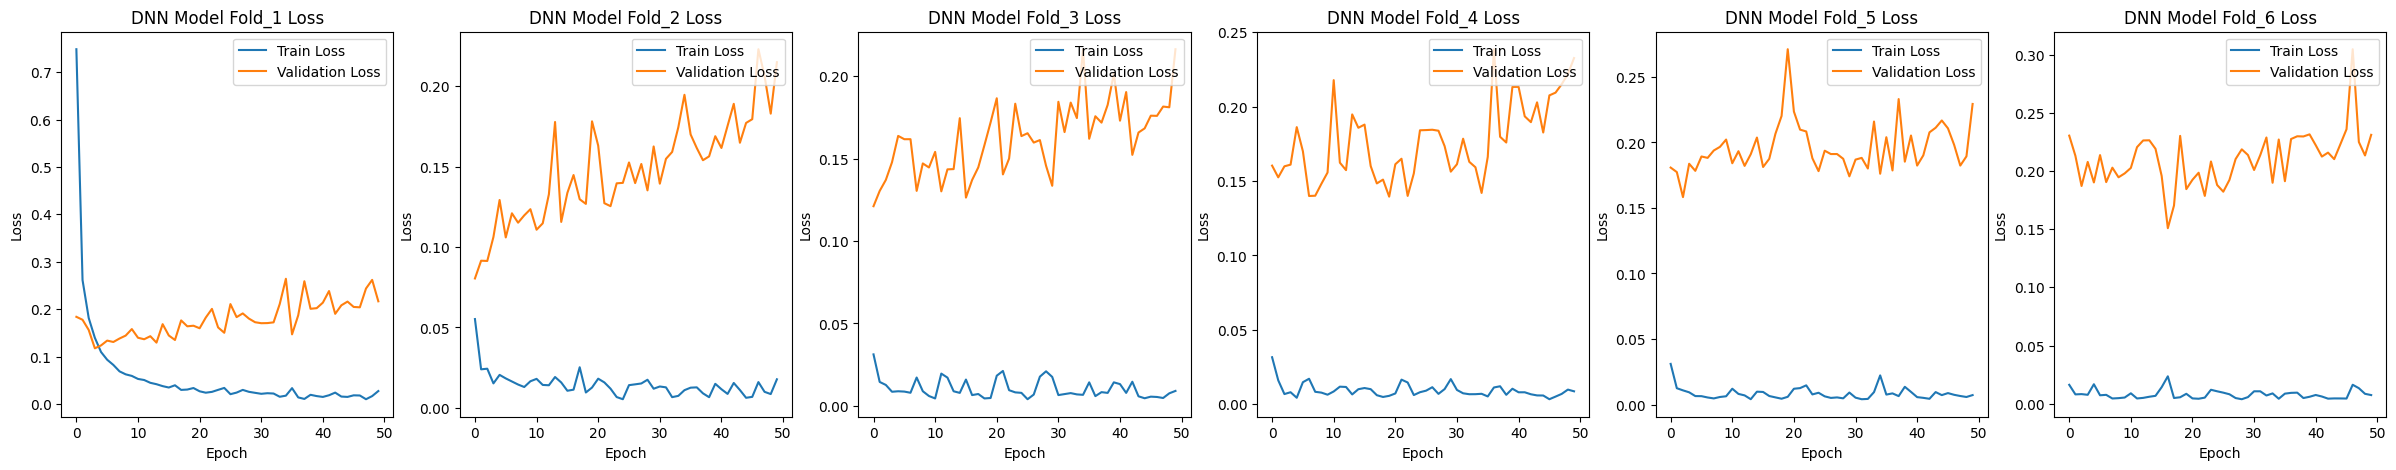

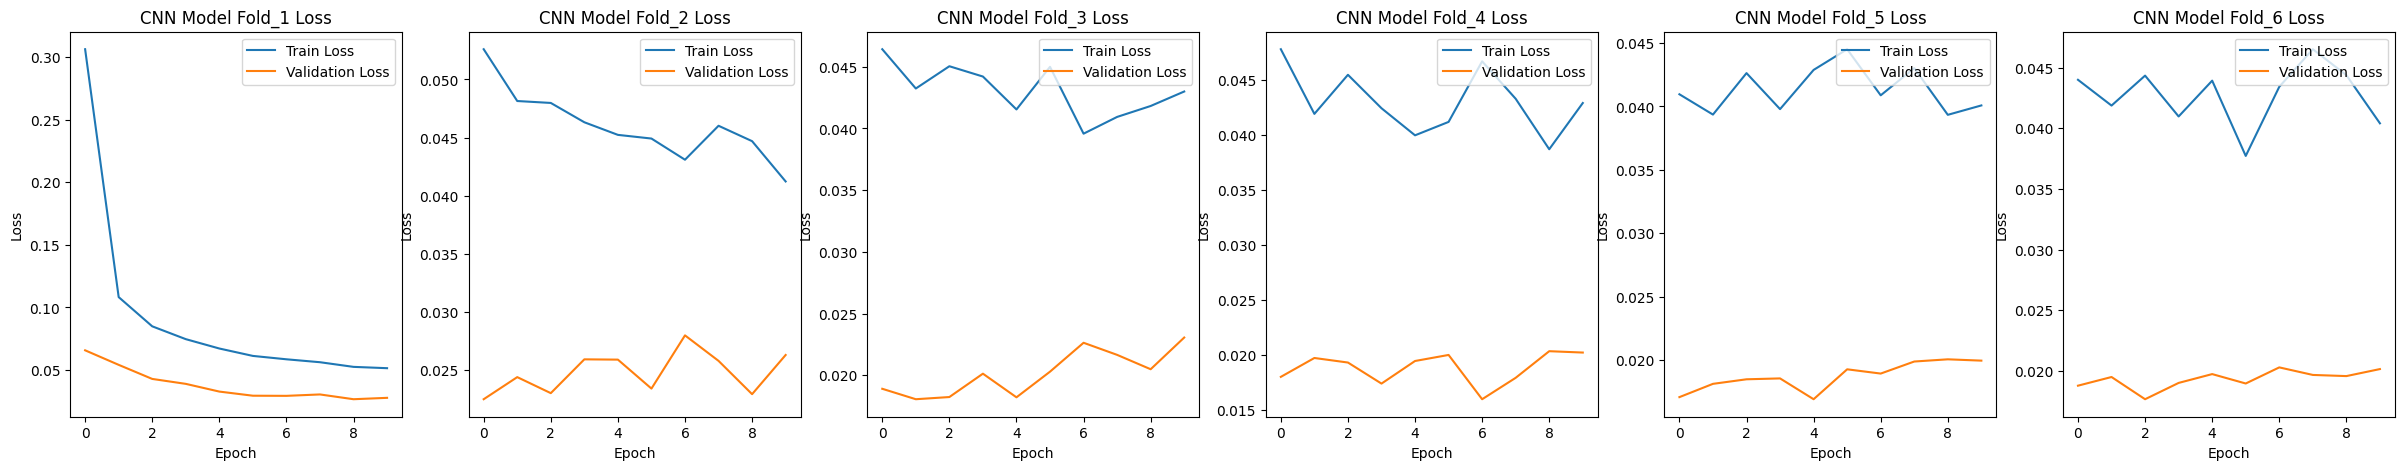

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(folds_history, model_type):


  # Plot training & validation loss values
  fig, axs = plt.subplots(1, 6, figsize=(30, 5))

  i = 0
  for fold in folds_history.keys():
    fold_vals = folds_history[fold].history

    axs[i].plot(fold_vals['loss'], label='Train Loss')
    axs[i].plot(fold_vals['val_loss'], label='Validation Loss')
    axs[i].set_title(f'{model_type} Model {fold} Loss')
    axs[i].set_ylabel('Loss')
    axs[i].set_xlabel('Epoch')

    axs[i].legend(loc='upper right')
    i += 1

  fig.savefig(f'result_files/loss_plots/{model_type}_loss_plot.png', bbox_inches='tight')
  plt.show()

# cnn_models, cnn_results_df, best_cnn_idx, cnn_models_hist

best_dnn_history = dnn_models_hist[f'Model_{best_dnn_idx + 1}']
best_cnn_history = cnn_models_hist[f'Model_{best_cnn_idx + 1}']

plot_loss(best_dnn_history, 'DNN')
plot_loss(best_cnn_history, 'CNN')


## Results Dataframes Extraction

In [ ]:
# concatenating the two results dataframes
all_results = pd.concat([dnn_results_df[best_dnn_idx], cnn_results_df[best_cnn_idx]])

# reindexing the df
all_results.index = [i for i in range(len(all_results))]

# showing the df
all_results

,Technique Name,Set,Fold Number,Accuracy,Precision,Recall,F1-Score
0,DNN,Train,1,0.997475,0.997408,0.997492,0.997445
1,DNN,Test,1,0.979900,0.979717,0.979920,0.979776
2,DNN,Train,2,0.997000,0.997046,0.996934,0.996977
3,DNN,Test,2,0.976400,0.976857,0.976043,0.976296
4,DNN,Train,3,0.996425,0.996501,0.996368,0.996417
5,DNN,Test,3,0.974000,0.974884,0.973583,0.973925
6,DNN,Train,4,0.999750,0.999737,0.999751,0.999744
7,DNN,Test,4,0.981200,0.981200,0.980963,0.981036
8,DNN,Train,5,0.999675,0.999672,0.999670,0.999671
9,DNN,Test,5,0.979800,0.979874,0.979611,0.979704


In [ ]:
# saving the dataframe
create_folder('result_files/dataframes')
all_results.to_csv('result_files/dataframes/erotima1.csv', index=False)

Folder result_files/dataframes created succesfully.


## Model Plots

In [61]:
from keras.utils import plot_model
from IPython.display import Image

create_folder('result_files/model_plots/all_models/DNN')
create_folder('result_files/model_plots/all_models/CNN')
create_folder('result_files/model_plots/best_models')

# plotting all dnn models
for i in range(len(dnn_models)):
  plot_model(dnn_models[i], to_file=f'result_files/model_plots/all_models/DNN/dnn_model_{i + 1}.png', show_shapes=True, show_layer_names=True)

# plotting all cnn models
for i in range(len(cnn_models)):
  plot_model(cnn_models[i], to_file=f'result_files/model_plots/all_models/CNN/cnn_model_{i + 1}.png', show_shapes=True, show_layer_names=True)


Folder result_files/model_plots/all_models/DNN created succesfully.
Folder result_files/model_plots/all_models/CNN created succesfully.
Folder result_files/model_plots/best_models created succesfully.


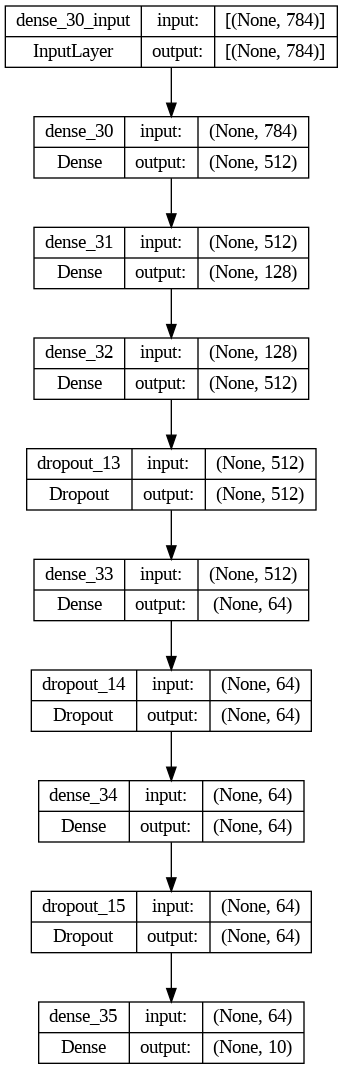

In [ ]:
# plotting the best dnn
plot_model(best_dnn, to_file=f'result_files/model_plots/best_models/dnn_best_model.png', show_shapes=True, show_layer_names=True)

# displaying the image
Image(f'result_files/model_plots/best_models/dnn_best_model.png')


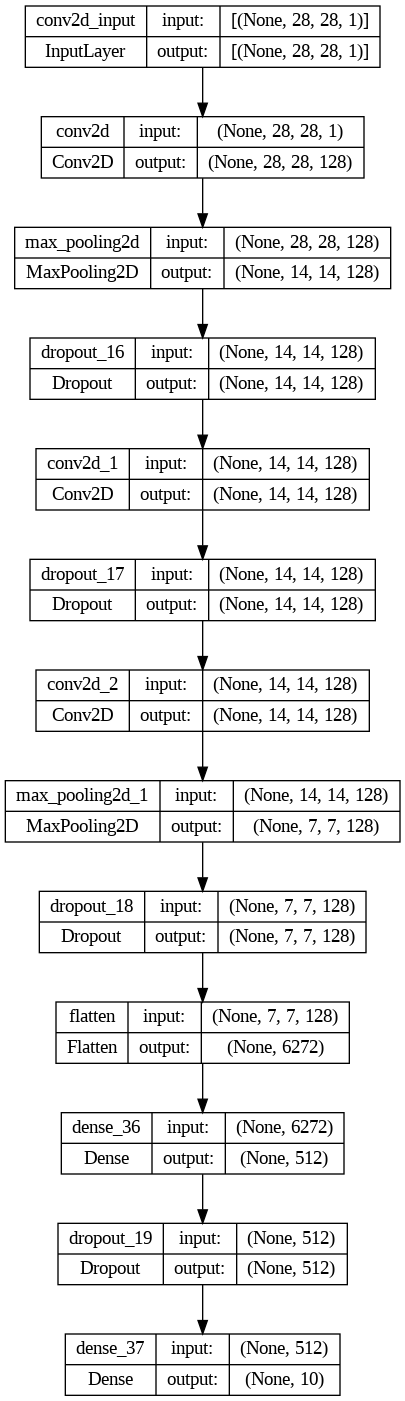

In [ ]:
# plotting the best cnn
plot_model(best_cnn, to_file=f'result_files/model_plots/best_models/cnn_best_model.png', show_shapes=True, show_layer_names=True)

# displaying the image
Image(f'result_files/model_plots/best_models/cnn_best_model.png')
